<a href="https://colab.research.google.com/github/mandalanil/Semi-Automated-workflow-for-flood-risk-mapping/blob/main/SpatioTemporal_GCN_GRU_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--- STEP 1: LOADING AND PREPROCESSING DATA ---
--- STEP 2: LOADING STATIC FEATURES AND COORDINATES ---
Successfully loaded 5 non-coordinate static feature rows and 13 features.
Using hardcoded coordinates for 5 HUCs.
Detected 5 HUCS (nodes). Total 15 features for each node (including Lat/Lon).
--- STEP 3: CREATING EVENT SAMPLES AND COMBINED FEATURES ---
Identified 151 total event start days across all HUCs.
Extracted 151 total 3-day (144-step) event samples.
--- STEP 4: SCALING STATISTICS AND DATA TRANSFORMATION ---
Final Input (X) shape: (151, 144, 5, 17)
Final Target (y) shape: (151, 144, 5)
--- STEP 5: CREATING NORMALIZED ADJACENCY MATRIX (A_norm) FROM COORDINATES ---
Graph constructed based on 3-NN spatial proximity (Undirected).
Graph loaded with 5 nodes and 9 edges.
A_norm matrix shape: (5, 5)
--- STEP 6: SPLITTING DATA (80/20) ---
Training Samples: 120, Testing Samples: 31

--- STEP 7: BUILDING GCN-GRU MODEL ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ event_input (InputLayer)        │ (None, 144, 5, 17)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gcn_layer (GCNLayer)            │ (None, 144, 5, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_for_rnn (Reshape)       │ (None, 144, 160)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer (GRU)                 │ (None, 144, 64)        │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 144, 5)         │           325 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,261 (172.89 KB)

 Trainable params: 44,261 (172.89 KB)

 Non-trainable params: 0 (0.00 B)


--- STEP 8: STARTING MODEL TRAINING ---
Epoch 1/50
4/4 - 10s - 3s/step - loss: 0.8161 - mae: 0.6071 - val_loss: 0.9920 - val_mae: 0.5961
Epoch 2/50
4/4 - 1s - 312ms/step - loss: 0.6998 - mae: 0.5410 - val_loss: 0.8522 - val_mae: 0.5258
Epoch 3/50
4/4 - 1s - 294ms/step - loss: 0.6002 - mae: 0.4798 - val_loss: 0.7153 - val_mae: 0.4537
Epoch 4/50
4/4 - 1s - 308ms/step - loss: 0.5060 - mae: 0.4212 - val_loss: 0.5793 - val_mae: 0.3919
Epoch 5/50
4/4 - 1s - 232ms/step - loss: 0.4202 - mae: 0.3802 - val_loss: 0.4380 - val_mae: 0.3465
Epoch 6/50
4/4 - 1s - 293ms/step - loss: 0.3246 - mae: 0.3485 - val_loss: 0.2900 - val_mae: 0.3058
Epoch 7/50
4/4 - 1s - 178ms/step - loss: 0.2406 - mae: 0.3182 - val_loss: 0.1565 - val_mae: 0.2451
Epoch 8/50
4/4 - 1s - 308ms/step - loss: 0.1819 - mae: 0.2876 - val_loss: 0.1201 - val_mae: 0.2169
Epoch 9/50
4/4 - 1s - 170ms/step - loss: 0.1734 - mae: 0.2834 - val_loss: 0.0924 - val_mae: 0.2000
Epoch 10/50
4/4 - 1s - 314ms/step - loss: 0.1555 - mae: 0.2742 - val_l

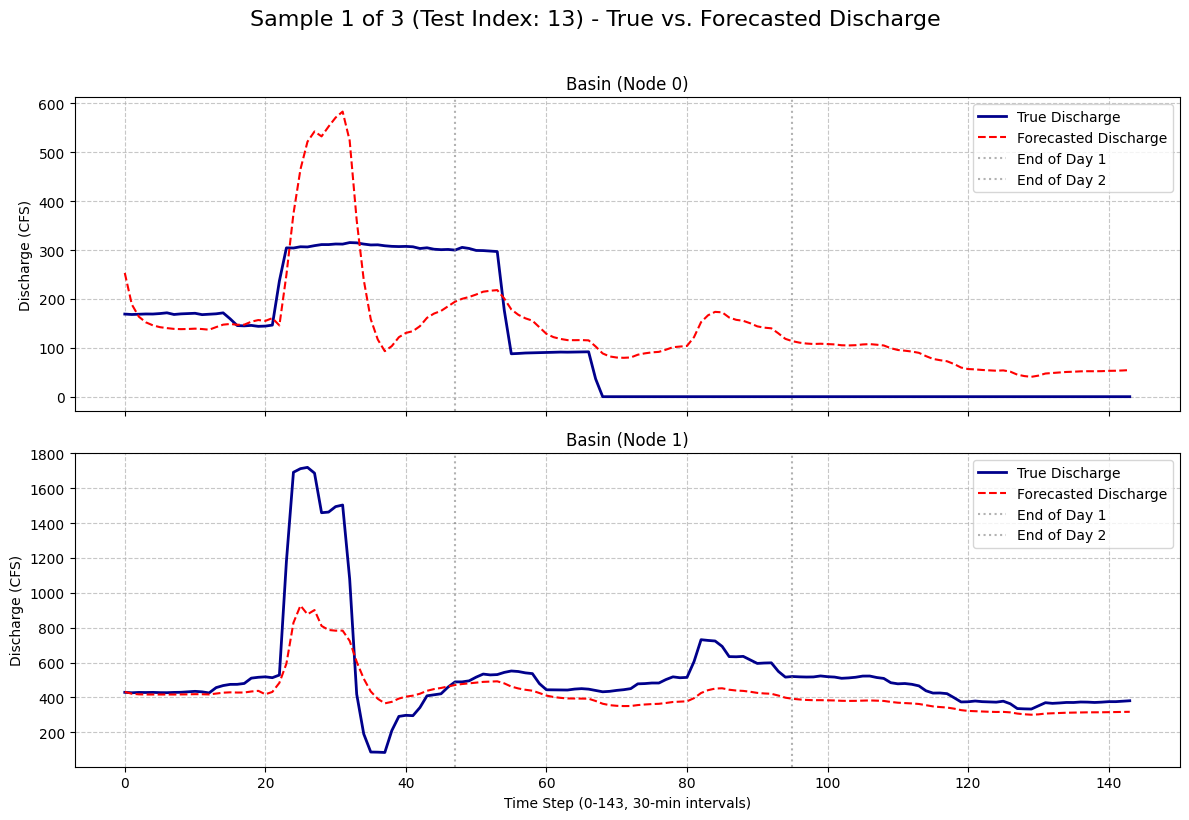

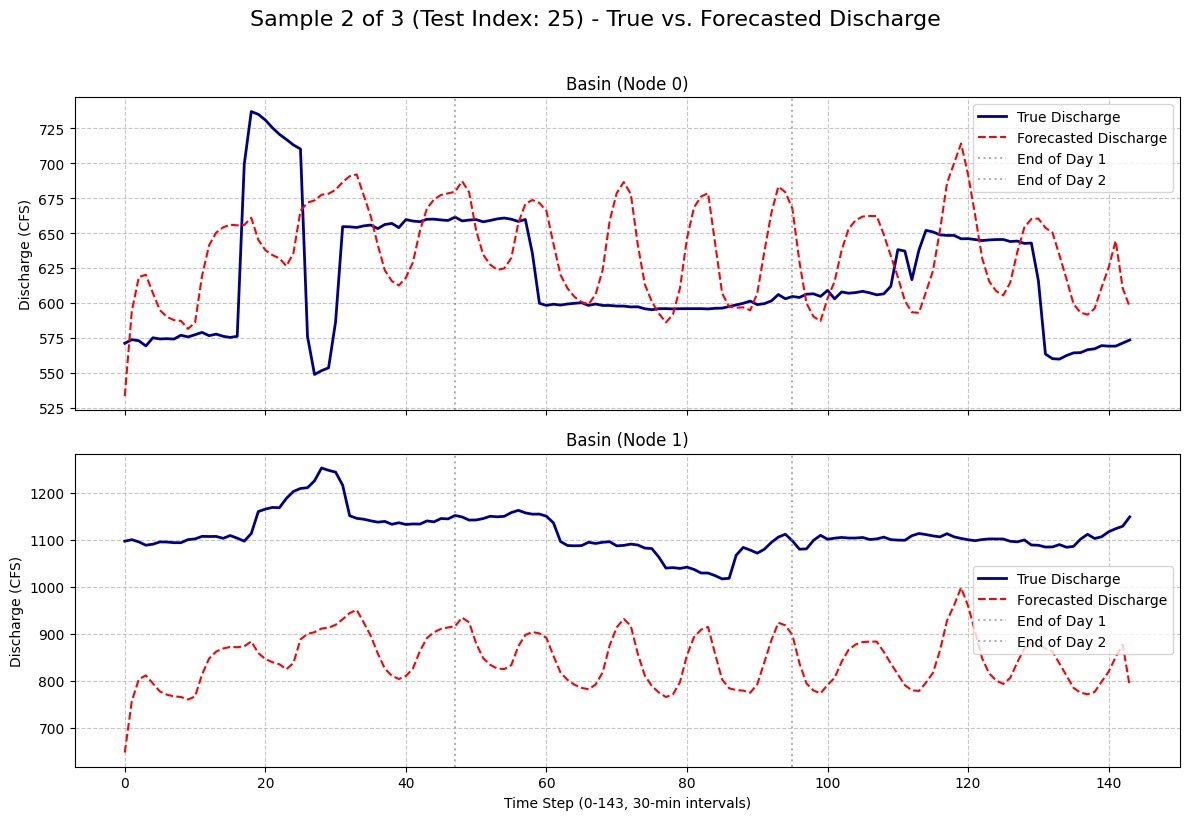

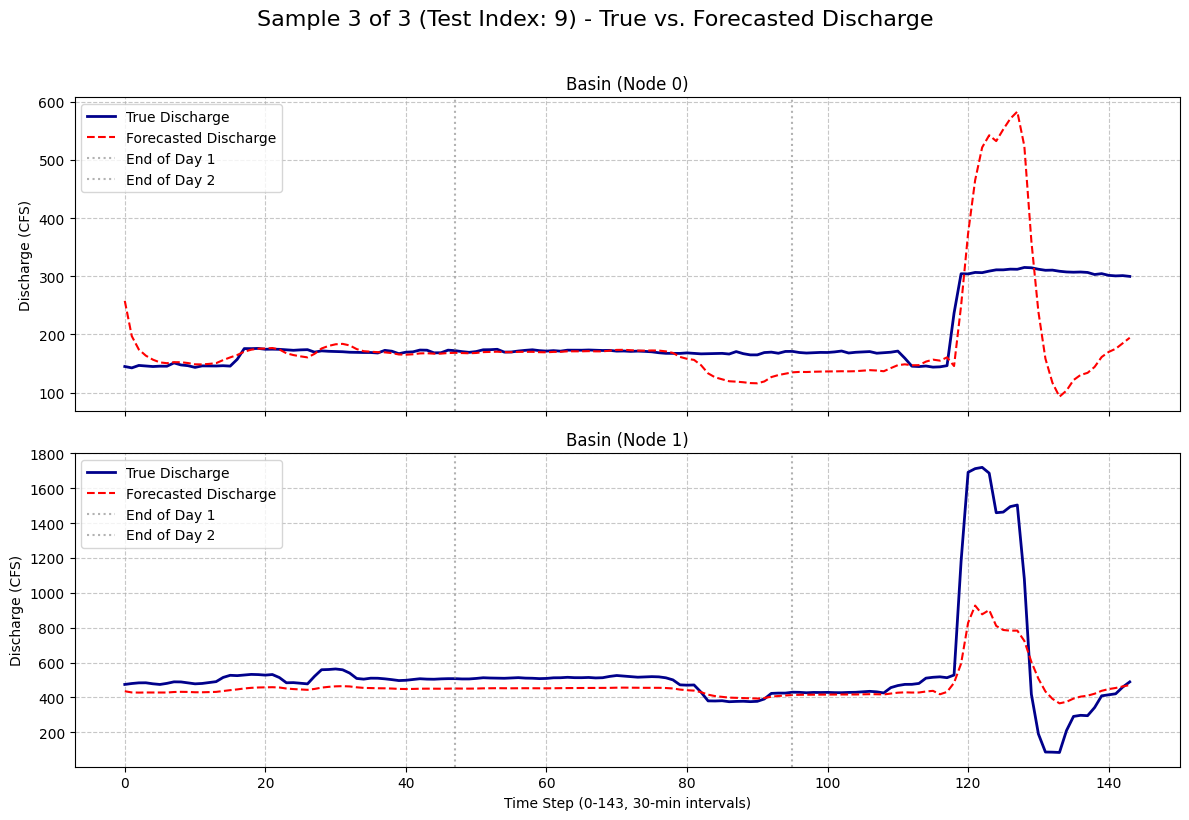

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors
from typing import Tuple
import random
import matplotlib.pyplot as plt
import os # Import os module

# --- GLOBAL PATHS AND PARAMETERS ---
BASE_PATH = '/content/drive/MyDrive/Final_Model_Data/'
STATIC_FEATURES_FILENAME = 'STATIC_FEATURES.csv' # File for non-coordinate static features
# COORDINATES_FILENAME has been removed, using HARDCODED_COORDINATE_DATA instead

TIME_SERIES_FILENAMES = [
    '030901012102_TIMESERIES_30MIN.csv',
    '030901030401_TIMESERIES_30MIN.csv',
    '030901030402_TIMESERIES_30MIN.csv',
    '030901012003_TIMESERIES_30MIN.csv',
    '030901012101_TIMESERIES_30MIN.csv'
]

# Hardcoded Coordinates (Based on HUC IDs from uploaded JSON structure)
HARDCODED_COORDINATE_DATA = {
    '030901012003': {'Latitude': 27.200, 'Longitude': -81.100},
    '030901012101': {'Latitude': 27.350, 'Longitude': -81.250},
    '030901012102': {'Latitude': 27.500, 'Longitude': -80.800},
    '030901030401': {'Latitude': 26.950, 'Longitude': -81.350},
    '030901030402': {'Latitude': 27.150, 'Longitude': -81.500}
}


# Model and Event Configuration
HORIZON_DAYS = 3
STEPS_PER_DAY = 48  # 24 hours * 2 (30-minute intervals)
EVENT_WINDOW_STEPS = HORIZON_DAYS * STEPS_PER_DAY  # 144
RAIN_THRESHOLD = 0.5  # inches
DRY_DAYS_THRESHOLD = 1
K_NEIGHBORS = 3
GCN_OUTPUT_DIM = 32
GRU_UNITS = 64
DROPOUT_RATE = 0.3
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 10
NUM_SAMPLES_TO_PLOT = 3

# --- GLOBAL GRAPH PLACEHOLDER ---
A_norm_global = None

# =========================================================================
# I. DATA PREPARATION FUNCTIONS
# =========================================================================

def load_all_timeseries(base_path, filenames):
    """Loads and preprocesses all 30-min time series data."""
    all_timeseries_list = []

    def load_and_preprocess_timeseries(filepath):
        try:
            temp_df = pd.read_csv(filepath)
            if temp_df.empty: return pd.DataFrame()

            temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'])
            temp_df = temp_df.set_index('Timestamp')

            huc12 = filepath.split('/')[-1].split('_')[0]
            temp_df['HUC12'] = huc12
            return temp_df[['HUC12', 'CFS', 'Inches']]
        except Exception as e:
            print(f"Error processing file {filepath}: {e}")
            return pd.DataFrame()

    for filename in filenames:
        full_path = base_path + filename
        temp_df = load_and_preprocess_timeseries(full_path)
        if not temp_df.empty:
            all_timeseries_list.append(temp_df)

    if not all_timeseries_list:
        raise FileNotFoundError("No time series data loaded.")

    df = pd.concat(all_timeseries_list)
    df.index.name = 'Timestamp'

    # Handle missing values
    df['CFS'] = df.groupby('HUC12')['CFS'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df['Inches'] = df.groupby('HUC12')['Inches'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df.dropna(inplace=True)

    # Pivot to create discharge and rainfall matrices
    df.sort_index(inplace=True)
    discharge_matrix = df.pivot(columns='HUC12', values='CFS')
    rainfall_matrix = df.pivot(columns='HUC12', values='Inches')

    return discharge_matrix, rainfall_matrix

def load_real_static_features(base_path, filename, expected_huc_ids):
    """
    Loads real static features (non-coordinate) from a CSV file.
    """
    try:
        filepath = base_path + filename
        static_df = pd.read_csv(filepath)

        if 'HUC12' not in static_df.columns:
            raise ValueError(f"Static features file ({filename}) must contain a 'HUC12' column.")

        static_df = static_df.set_index('HUC12')

        # Select and reorder HUCs to match the time series data
        # Use reindex to handle potential missing HUCs more gracefully
        static_features_df = static_df.reindex(expected_huc_ids).copy()

        # Drop Lat/Lon if they accidentally appear in this file, as they will be merged later
        static_features_df = static_features_df.drop(columns=['Latitude', 'Longitude'], errors='ignore')

        # Keep only numeric columns
        numeric_cols = static_features_df.select_dtypes(include=np.number).columns
        static_features_df = static_features_df[numeric_cols]

        # Handle missing values created by reindex
        if static_features_df.isnull().any().any():
            print("Warning: Some HUC IDs in time series data were not found in the static features file. Filling missing static features with zeros.")
            static_features_df.fillna(0, inplace=True)


        print(f"Successfully loaded {len(static_features_df)} non-coordinate static feature rows and {len(numeric_cols)} features.")
        return static_features_df

    except FileNotFoundError:
        print(f"Error: Static features file not found at {filepath}. Creating dummy static features.")
        # Create a dummy file and then load it
        create_dummy_static_features_file(filepath, expected_huc_ids)
        return load_real_static_features(base_path, filename, expected_huc_ids) # Recurse to load the newly created dummy file
    except KeyError as e:
        print(f"Error: Mismatch in HUC IDs between time series and static data. Some expected HUC IDs not found in static data: {e}. Creating dummy static features for missing IDs.")
        # Reindex already handles this, but adding an explicit message
        return static_features_df.fillna(0) # Return the partially loaded data with missing filled
    except ValueError as e:
        print(f"Error: {e}. Creating dummy static features.")
        create_dummy_static_features_file(filepath, expected_huc_ids)
        return load_real_static_features(base_path, filename, expected_huc_ids)


def create_dummy_static_features_file(filepath, huc_ids):
    """Creates a dummy static features CSV file if the real one is not found."""
    print(f"Creating DUMMY static features file at {filepath}.")

    feature_names = [
        'Min_Elevation_m', 'Max_Elevation_m', 'Mean_Elevation_m', 'Median_Elevation_m',
        'Std_Dev_Elevation_m', 'Min_Slope_deg', 'Max_Slope_deg', 'Mean_Slope_deg',
        'Median_Slope_deg', 'Std_Dev_Slope_deg', 'Composite_CN', 'Area_ha', 'Dummy_Feature_1'
    ]

    data = {}
    for i, name in enumerate(feature_names):
        # Use a simple counter + fixed seed for reproducibility without hash issues
        np.random.seed(42 + i)
        data[name] = np.round(np.random.rand(len(huc_ids)) * 100, 2)

    dummy_df = pd.DataFrame(data, index=huc_ids)
    dummy_df.index.name = 'HUC12'

    # Ensure the directory exists before saving
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    dummy_df.to_csv(filepath)
    print(f"Dummy static features file saved to {filepath}")


def get_hardcoded_coordinate_data(expected_huc_ids):
    """
    Creates a DataFrame from the globally defined HARDCODED_COORDINATE_DATA.
    """
    data = {huc: HARDCODED_COORDINATE_DATA.get(huc, {'Latitude': np.nan, 'Longitude': np.nan})
            for huc in expected_huc_ids}

    coord_df = pd.DataFrame.from_dict(data, orient='index', columns=['Latitude', 'Longitude'])
    coord_df.index.name = 'HUC12'

    # Fill missing coordinates with random dummy values if the hardcoded data was incomplete
    if coord_df.isnull().any().any():
        print("Warning: Hardcoded coordinate data was incomplete for some HUCs. Filling with dummy coordinates.")
        dummy_df = create_dummy_coordinates(coord_df[coord_df['Latitude'].isna()].index.tolist())
        coord_df.update(dummy_df)

    print(f"Using hardcoded coordinates for {len(coord_df)} HUCs.")
    return coord_df


def create_dummy_coordinates(huc_ids):
    """Creates dummy coordinate data."""
    # Used as a final fallback if HUC IDs are missing from hardcoded data
    np.random.seed(42)
    data = {
        'Latitude': np.round(40 + np.random.rand(len(huc_ids)) * 5, 4),
        'Longitude': np.round(-100 + np.random.rand(len(huc_ids)) * 5, 4)
    }
    return pd.DataFrame(data, index=huc_ids)

def identify_and_extract_events(discharge_matrix, rainfall_matrix, static_features_df):
    """Identifies event start times and extracts 30-min event windows."""

    # 1. Daily Aggregation for Event Identification
    daily_rainfall_df = rainfall_matrix.resample('D').sum()
    rainfall_3day_sum = daily_rainfall_df.rolling(window=HORIZON_DAYS, min_periods=HORIZON_DAYS).sum()
    is_dry = (daily_rainfall_df == 0)

    dry_period_ending_before_event = is_dry.rolling(window=DRY_DAYS_THRESHOLD, min_periods=DRY_DAYS_THRESHOLD).apply(lambda x: np.prod(x), raw=True)

    # 2. Identify Event Start Days
    sum_threshold_met_at_end_day = (rainfall_3day_sum >= RAIN_THRESHOLD)
    sum_met_aligned_to_start = sum_threshold_met_at_end_day.shift(- (HORIZON_DAYS - 1) )
    dry_period_met_aligned_to_start = dry_period_ending_before_event.shift(1)

    event_start_mask = (sum_met_aligned_to_start == True) & (dry_period_met_aligned_to_start == True)
    event_start_mask = event_start_mask.fillna(False)

    print(f"Identified {event_start_mask.sum().sum()} total event start days across all HUCs.")

    # 3. Extract 30-Minute Event Samples
    event_samples = []
    static_features_array = static_features_df.values # Use the full static_features_df
    num_static_features = static_features_df.shape[1]

    for huc_id in event_start_mask.columns:
        for time_index, row in event_start_mask.iterrows():
            if row[huc_id]:
                event_start_time_30min = pd.to_datetime(time_index.strftime('%Y-%m-%d 00:00:00'))
                event_end_time_30min = event_start_time_30min + pd.Timedelta(minutes=(EVENT_WINDOW_STEPS - 1) * 30)

                if event_end_time_30min > rainfall_matrix.index.max(): continue

                try:
                    rainfall_window = rainfall_matrix.loc[event_start_time_30min:event_end_time_30min].values
                    discharge_window = discharge_matrix.loc[event_start_time_30min:event_end_time_30min].values
                except KeyError:
                    continue

                if len(rainfall_window) != EVENT_WINDOW_STEPS: continue

                # Stack dynamic features: (T, N, 2)
                dynamic_stacked = np.stack([discharge_window, rainfall_window], axis=-1)

                # Repeat static features: (T, N, N_static_features)
                static_repeated = np.tile(static_features_array[np.newaxis, :, :], (EVENT_WINDOW_STEPS, 1, 1))

                # Combined features: (T, N, 2 + N_static_features)
                combined_features = np.concatenate([dynamic_stacked, static_repeated], axis=-1)

                event_samples.append({
                    'event_huc_id': huc_id,
                    'rainfall_data': rainfall_window,
                    'discharge_data': discharge_window,
                    'combined_features': combined_features
                })

    return event_samples, num_static_features

def calculate_scaling_stats(discharge_matrix, rainfall_matrix, static_features_df):
    """Calculates scaling statistics from the full dataset."""
    num_timesteps_30min = discharge_matrix.shape[0]
    num_static_features = static_features_df.shape[1]
    total_features = 2 + num_static_features

    # 1. Create full combined feature array
    static_full = np.tile(static_features_df.values[np.newaxis,:,:], (num_timesteps_30min, 1, 1))
    dynamic_stacked_full = np.stack([discharge_matrix.values, rainfall_matrix.values], axis=-1)
    combined_full = np.concatenate([dynamic_stacked_full, static_full], axis=-1)

    # 2. Reshape for mean/std calculation: (Timesteps * Nodes, Total_Features)
    reshaped_full = combined_full.reshape(-1, total_features)

    # 3. Calculate mean and std
    mean_stats = np.mean(reshaped_full, axis=0)
    std_stats = np.std(reshaped_full, axis=0)

    # Handle zero std to avoid division by zero
    std_stats[std_stats == 0] = 1e-8

    return mean_stats, std_stats, total_features

def scale_event_samples(event_samples, mean_stats, std_stats, total_features):
    """Scales all event samples using the calculated statistics."""
    X_list = []
    y_list = []

    # Index 0 is Discharge (the target feature)
    discharge_mean = mean_stats[0]
    discharge_std = std_stats[0]

    for sample in event_samples:
        combined_features = sample['combined_features']
        discharge_target = sample['discharge_data']

        # Scale X (Input features)
        reshaped_X = combined_features.reshape(-1, total_features)
        scaled_X = (reshaped_X - mean_stats) / std_stats
        scaled_X = scaled_X.reshape(combined_features.shape)
        X_list.append(scaled_X)

        # Scale y (Target discharge)
        reshaped_y = discharge_target.reshape(-1, 1)
        scaled_y = (reshaped_y - discharge_mean) / discharge_std
        scaled_y = scaled_y.reshape(discharge_target.shape)
        y_list.append(scaled_y)

    X_events = np.array(X_list, dtype=np.float32)
    y_events = np.array(y_list, dtype=np.float32)

    return X_events, y_events

def create_graph_from_coords_and_normalize(huc_ids, static_features_df, k_neighbors=K_NEIGHBORS):
    """
    Constructs an UNDIRECTED graph based on spatial proximity (k-NN) using coordinates
    from the static features DataFrame, then calculates the Normalized Adjacency Matrix (A_norm).
    """
    # 1. Extract Coordinates
    if 'Latitude' not in static_features_df.columns or 'Longitude' not in static_features_df.columns:
        print("FATAL ERROR: Static features must contain 'Latitude' and 'Longitude' for graph construction. Falling back to Identity Matrix.")
        return np.eye(len(huc_ids), dtype=np.float32)

    coords = static_features_df[['Latitude', 'Longitude']].values

    # 2. Compute Distance Matrix and find k-NN
    # We use k_neighbors + 1 because the first neighbor is always the node itself.
    nbrs = NearestNeighbors(n_neighbors=min(k_neighbors + 1, len(huc_ids)), algorithm='ball_tree').fit(coords) # Added min to handle case where num_nodes < k_neighbors
    distances, indices = nbrs.kneighbors(coords)

    G = nx.Graph()
    for i in range(len(huc_ids)):
        for j in indices[i]:
            if i != j:
                huc_i = huc_ids[i]
                huc_j = huc_ids[j]
                G.add_edge(huc_i, huc_j)

    # 3. Get Adjacency Matrix (A) in the correct HUC order
    # Ensure all huc_ids are in the graph before creating adjacency matrix
    missing_hucs = [h for h in huc_ids if h not in G.nodes()]
    if missing_hucs:
        print(f"Warning: The following HUC IDs are in the data but were not added to the graph: {missing_hucs}. This might happen if k_neighbors is too small relative to the number of nodes. Adding them as isolated nodes.")
        for huc in missing_hucs:
            G.add_node(huc)


    A = nx.adjacency_matrix(G, nodelist=huc_ids, dtype=np.float32).todense()
    A = np.array(A)

    # 4. Add Self-loops (A_hat = A + I)
    I = np.eye(A.shape[0], dtype=np.float32)
    A_hat = A + I

    # 5. Calculate Degree Matrix (D_hat)
    degrees_hat = np.array(A_hat.sum(axis=1)).flatten()
    D_hat_inv_sqrt = np.zeros_like(A_hat)

    # Handle zero degrees
    non_zero_degrees_hat_indices = np.where(degrees_hat != 0)[0]
    D_hat_inv_sqrt[non_zero_degrees_hat_indices, non_zero_degrees_hat_indices] = 1.0 / np.sqrt(degrees_hat[non_zero_degrees_hat_indices])

    # 6. Calculate Normalized Adjacency Matrix (A_norm)
    A_norm = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt

    print(f"Graph constructed based on {min(k_neighbors, len(huc_ids)-1)}-NN spatial proximity (Undirected).") # Updated message
    print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    print(f"A_norm matrix shape: {A_norm.shape}")

    return A_norm

# =========================================================================
# II. GCN-GRU MODEL DEFINITIONS
# =========================================================================

class GCNLayer(tf.keras.layers.Layer):
    """
    Graph Convolutional Layer: H' = A_norm * H * W
    Input shape: (batch_size, time_steps, num_nodes, feature_dim)
    """
    def __init__(self, output_dim, activation='relu', **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.output_dim),
                                      initializer='glorot_uniform',
                                      name='kernel')
        super(GCNLayer, self).build(input_shape)

    def call(self, inputs):
        # Access the globally set A_norm matrix
        A_norm_tensor = tf.constant(A_norm_global, dtype=tf.float32)

        # 1. Reshape for batch processing: (batch*time, num_nodes, feature_dim)
        H = tf.reshape(inputs, (-1, tf.shape(inputs)[-2], tf.shape(inputs)[-1]))

        # 2. H * W (Feature transformation)
        H_W = tf.einsum('ijk,kp->ijp', H, self.kernel)

        # 3. A_norm * (H * W) (Spatial aggregation/Graph Convolution)
        A_H_W = tf.einsum('ij,bjk->bik', A_norm_tensor, H_W)

        # 4. Reshape back to (batch_size, time_steps, num_nodes, output_dim)
        output = tf.reshape(A_H_W, (tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[-2], self.output_dim))
        return self.activation(output)

def build_gcn_gru_model(
    input_shape: Tuple,
    num_nodes: int,
    output_steps: int,
    gcn_output_dim: int = GCN_OUTPUT_DIM,
    gru_units: int = GRU_UNITS,
    dropout_rate: float = DROPOUT_RATE
) -> Model:
    """Defines the true Spatio-Temporal GCN-GRU model."""

    event_input = Input(shape=input_shape, name='event_input')

    # 1. Spatial Feature Extraction (GCN)
    gcn_out = GCNLayer(output_dim=gcn_output_dim, activation='relu', name='gcn_layer')(event_input)

    # 2. Reshape for Temporal Layer (GRU)
    # Calculate the correct size for the flattened dimension
    flattened_dim = num_nodes * gcn_output_dim
    reshaped_for_rnn = Reshape(
        (output_steps, flattened_dim), # Use the calculated flattened_dim
        name='reshape_for_rnn'
    )(gcn_out)

    # 3. Temporal Modeling (GRU)
    gru_out = GRU(
        units=gru_units,
        activation='relu',
        return_sequences=True,
        name='gru_layer'
    )(reshaped_for_rnn)

    gru_out = Dropout(dropout_rate, name='dropout')(gru_out)

    # 4. Output Layer
    output_dense = TimeDistributed(
        Dense(num_nodes, name='output_dense'),
        name='time_distributed_output'
    )(gru_out)

    model = Model(inputs=event_input, outputs=output_dense)
    return model

# =========================================================================
# III. MAIN EXECUTION BLOCK (Training and Evaluation)
# =========================================================================

if __name__ == '__main__':

    # 1. RUN DATA PREPARATION
    print("--- STEP 1: LOADING AND PREPROCESSING DATA ---")
    try:
        discharge_matrix, rainfall_matrix = load_all_timeseries(BASE_PATH, TIME_SERIES_FILENAMES)
    except FileNotFoundError as e:
        print(f"FATAL ERROR: {e}")
        exit()

    huc_ids = discharge_matrix.columns.tolist()
    num_nodes = len(huc_ids)

    # 2. LOAD STATIC FEATURES (NON-COORDINATE) AND COORDINATES SEPARATELY
    print("--- STEP 2: LOADING STATIC FEATURES AND COORDINATES ---")

    # Load non-coordinate static features
    # This function now handles the FileNotFoundError and creates a dummy file if needed
    non_coord_static_df = load_real_static_features(BASE_PATH, STATIC_FEATURES_FILENAME, huc_ids)

    # Get coordinate data from hardcoded source
    coord_df = get_hardcoded_coordinate_data(huc_ids)

    # Merge the two DataFrames into one consolidated static features DataFrame
    # Ensure the order of HUC IDs is consistent by reindexing the non_coord_static_df
    # before joining. This also handles cases where some HUCs might be missing from
    # the static file by adding rows of NaNs that are then filled by load_real_static_features.
    static_features_df = non_coord_static_df.reindex(huc_ids).join(coord_df.reindex(huc_ids), how='inner')


    # Final check on feature set - Ensure at least Lat/Lon features are present
    if 'Latitude' not in static_features_df.columns or 'Longitude' not in static_features_df.columns:
         print("FATAL ERROR: Latitude and Longitude features are missing after loading and merging static data.")
         # Fallback to creating dummy coordinates if missing, and add to the dataframe
         dummy_coord_df = create_dummy_coordinates(huc_ids)
         static_features_df = static_features_df.join(dummy_coord_df, how='left', lsuffix='_existing', rsuffix='_dummy')
         # Use dummy coordinates where the real ones were missing
         static_features_df['Latitude'] = static_features_df['Latitude_existing'].fillna(static_features_df['Latitude_dummy'])
         static_features_df['Longitude'] = static_features_df['Longitude_existing'].fillna(static_features_df['Longitude_dummy'])
         static_features_df = static_features_df.drop(columns=['Latitude_existing', 'Longitude_existing', 'Latitude_dummy', 'Longitude_dummy'], errors='ignore')
         print("Filled missing Latitude/Longitude with dummy coordinates.")

    if static_features_df.empty or static_features_df.shape[1] < 2:
         print("FATAL ERROR: No valid static features available after attempting to load and create dummies.")
         exit()


    print(f"Detected {num_nodes} HUCS (nodes). Total {len(static_features_df.columns)} features for each node (including Lat/Lon).")

    print("--- STEP 3: CREATING EVENT SAMPLES AND COMBINED FEATURES ---")
    # Pass the full static_features_df including Lat/Lon
    event_samples, num_static_features_in_events = identify_and_extract_events(discharge_matrix, rainfall_matrix, static_features_df)
    print(f"Extracted {len(event_samples)} total 3-day (144-step) event samples.")

    print("--- STEP 4: SCALING STATISTICS AND DATA TRANSFORMATION ---")
    # Recalculate total_features based on the actual number of columns in static_features_df
    total_features = 2 + static_features_df.shape[1] # 2 for dynamic (CFS, Inches) + static features
    mean_stats, std_stats, calculated_total_features = calculate_scaling_stats(discharge_matrix, rainfall_matrix, static_features_df)

    # Assert that the number of features in event samples matches the calculated total features
    if event_samples and event_samples[0]['combined_features'].shape[-1] != calculated_total_features:
        print(f"FATAL ERROR: Feature count mismatch! Event samples have {event_samples[0]['combined_features'].shape[-1]} features, but calculated total features is {calculated_total_features}.")
        exit()

    X_events, y_events = scale_event_samples(event_samples, mean_stats, std_stats, calculated_total_features)

    print(f"Final Input (X) shape: {X_events.shape}")
    print(f"Final Target (y) shape: {y_events.shape}")

    print("--- STEP 5: CREATING NORMALIZED ADJACENCY MATRIX (A_norm) FROM COORDINATES ---")
    # Use the full static_features_df which now includes coordinates
    A_norm = create_graph_from_coords_and_normalize(huc_ids, static_features_df)

    # CRITICAL: SET THE GLOBAL A_NORM VARIABLE FOR THE GCNLAYER
    global A_norm_global
    A_norm_global = A_norm

    # 6. SPLIT DATA (80/20)
    print("--- STEP 6: SPLITTING DATA (80/20) ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X_events, y_events, test_size=0.2, random_state=42
    )
    print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

    # 7. BUILD MODEL
    print("\n--- STEP 7: BUILDING GCN-GRU MODEL ---")
    # Use the recalculated total_features for the input shape
    input_shape = (EVENT_WINDOW_STEPS, num_nodes, calculated_total_features)
    gcn_gru_model = build_gcn_gru_model(
        input_shape=input_shape,
        num_nodes=num_nodes,
        output_steps=EVENT_WINDOW_STEPS
    )

    # 8. COMPILE MODEL
    gcn_gru_model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    gcn_gru_model.summary()

    # 9. TRAIN MODEL
    print("\n--- STEP 8: STARTING MODEL TRAINING ---")
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    history = gcn_gru_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=validation_dataset,
        callbacks=[early_stopping],
        verbose=2
    )
    print("\nModel training complete.")

    # 10. EVALUATION
    print("\n--- STEP 9: MODEL EVALUATION ---")

    y_pred_events = gcn_gru_model.predict(X_test)

    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred_events.flatten()

    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"R-squared (R^2) on the Test Set: {r2:.4f}")

    # Unscale for visualization
    # Use the correct index for discharge mean/std
    discharge_mean = mean_stats[0]
    discharge_std = std_stats[0]
    y_true_unscaled_all = y_test * discharge_std + discharge_mean
    y_pred_unscaled_all = y_pred_events * discharge_std + discharge_mean

    # 11. VISUALIZATION: MULTIPLE SAMPLES AND BASINS
    print(f"\n--- STEP 10: VISUALIZING {NUM_SAMPLES_TO_PLOT} RANDOM TEST SAMPLES ---")

    test_sample_indices = random.sample(range(X_test.shape[0]), min(NUM_SAMPLES_TO_PLOT, X_test.shape[0]))

    # We will plot Node 0 and Node 1 for visual comparison across samples.
    # Ensure nodes to plot are within the valid range of nodes
    nodes_to_plot = [node_idx for node_idx in [0, 1] if node_idx < num_nodes]

    if not nodes_to_plot:
        print("Cannot plot: No nodes available.")
    else:
        for i, sample_index in enumerate(test_sample_indices):

            fig, axes = plt.subplots(len(nodes_to_plot), 1, figsize=(12, 4 * len(nodes_to_plot)), sharex=True)
            fig.suptitle(f'Sample {i+1} of {len(test_sample_indices)} (Test Index: {sample_index}) - True vs. Forecasted Discharge', fontsize=16, y=1.02)

            # Ensure axes is iterable even for a single subplot
            if len(nodes_to_plot) == 1:
                axes = [axes]

            for j, node_index in enumerate(nodes_to_plot):

                ax = axes[j]

                # Plot True (Actual) Discharge
                ax.plot(y_true_unscaled_all[sample_index, :, node_index],
                        label='True Discharge', color='darkblue', linewidth=2)

                # Plot Predicted (Forecasted) Discharge
                ax.plot(y_pred_unscaled_all[sample_index, :, node_index],
                        label='Forecasted Discharge', color='red', linestyle='--', linewidth=1.5)

                # Day markers
                ax.axvline(x=47, color='grey', linestyle=':', alpha=0.6, label='End of Day 1')
                ax.axvline(x=95, color='grey', linestyle=':', alpha=0.6, label='End of Day 2')

                ax.set_title(f'Basin (Node {node_index})')
                ax.set_ylabel('Discharge (CFS)')
                ax.legend()
                ax.grid(True, linestyle='--', alpha=0.7)

            axes[-1].set_xlabel('Time Step (0-143, 30-min intervals)') # Set xlabel only on the bottom plot
            plt.tight_layout()
            plt.show()